In [1]:
from __future__ import division
from scipy.ndimage.filters import convolve
import numpy as np
import os
import cv2
import itertools
from matplotlib import pyplot as plt


In [4]:

def ldp(face, top_k=3):
    assert face.ndim == 2
    face = np.array(face).astype('int32')

    # Kirsch masks in 8 directions
    EAST = np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]])
    NORTH_EAST = np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]])
    NORTH = np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]])
    NORTH_WEST = np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]])
    WEST = np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]])
    SOUTH_WEST = np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]])
    SOUTH = np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]])
    SOUTH_EAST = np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]])

    KIRCHS = []

    # Convolution of the image with the masks
    for MASK in [EAST, NORTH_EAST, NORTH, NORTH_WEST, WEST, SOUTH_WEST, SOUTH, SOUTH_EAST]:
        KIRCHS.append(convolve(face, MASK, mode='reflect'))

    # Placeholder for storing the ldp code values for the individual pixels of the image
    LDP = [[0 for i in range(face.shape[1])] for j in range(face.shape[0])]

    # Hyperparameter to choose the top k maximum ldp code values for the particular pixel
    TOP_K = top_k

    # Generating the code value for the individual pixel
    for row in range(face.shape[0]):
        for col in range(face.shape[1]):
            m = sorted([(abs(KIRCH[row, col]), i)
                       for i, KIRCH in enumerate(KIRCHS)], reverse=True)
            k = 0
            for (_, i) in m[:TOP_K]:
                k |= (1 << i)
            LDP[row][col] = k
    LDP = np.array(LDP, dtype=np.uint8)
    return LDP


def generate_binary(n=8, top_k=3):
    L = []
    for setbits in itertools.combinations(range(n), top_k):
        s = [0] * n
        for setbit in setbits:
            s[setbit] = 1
        L.append(s)
    return L


def convert_to_decimal(s):
    L, k = [], 0
    for i, bit in enumerate(s):
        if bit == 1:
            k |= (1 << i)
    return k


C = [1, 8, 28, 56, 70, 56, 28, 8, 1]

# Histogram feature descriptor for the ldp code image


def histogram_descriptor(ldp, top_k=3, patch_width=8, patch_height=8):
    histogram = []
    ss = generate_binary(top_k=top_k)
    De = [convert_to_decimal(s) for s in ss]
    for row in range(0, ldp.shape[0], patch_width):
        for col in range(1, ldp.shape[1], patch_height):
            counter = {d: 0 for d in De}
            patch = ldp[row: row+patch_height, col: col+patch_width]
            for pixel in patch.ravel():
                counter[pixel] = counter[pixel] + 1
            hist = [counter[key] / C[top_k] for key in sorted(counter.keys())]
            histogram += hist
    return np.array(histogram)


[196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 38, 38, 196, 196, 38, 38, 196, 196, 196, 196, 196, 196, 38, 38, 196, 196, 134, 7, 224, 224, 146, 49, 196, 134, 52, 50, 7, 224, 224, 176, 50, 19, 49, 224, 224, 146, 25, 137, 7, 146, 49, 146, 145, 13, 152, 137, 140, 152, 152, 137, 140, 152, 145, 145, 145, 145, 145, 145, 145, 49, 145, 145, 145, 49, 145, 145, 145, 49, 49, 49, 19, 49, 49, 49, 49, 49, 19, 49, 49, 49, 49, 50, 35, 38, 38, 196, 140, 140, 137, 137, 140, 140, 152, 145, 145, 137, 140, 140, 140, 140, 152, 137, 140, 140, 140, 140, 196, 196, 196, 140, 196, 100, 38, 196, 38, 38, 52, 35, 38, 38, 196, 145, 22, 145, 49, 49, 19, 49, 49, 19, 19, 49, 38, 52, 50, 50, 50, 50, 52, 100, 50, 35, 196, 52, 38, 196, 134, 7, 176, 50, 50, 38, 196, 196, 52, 35, 196, 137, 196, 134, 7, 224, 224, 28, 145, 49, 196, 134, 38, 38, 196, 196, 50, 49, 50, 49, 49, 49, 19, 145, 49, 50, 19, 145, 49, 49, 19, 49, 176, 100, 196, 50, 35, 50, 19, 49, 49, 49, 49, 49, 49, 49, 

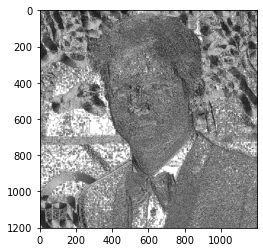

array([[196, 196, 196, ...,  38,  38,  38],
       [ 76,  76,  76, ..., 100,  70, 100],
       [ 76,  76,  76, ...,  70,  70, 100],
       ...,
       [196, 134, 196, ..., 140, 134, 164],
       [ 76,  98,  98, ..., 200,  70,  98],
       [224, 146,  49, ...,  49, 146,  49]], dtype=uint8)

In [5]:
photo1 = cv2.imread("img.jpg")
# converting image to grayscale
gray_scale = cv2.cvtColor(photo1, cv2.COLOR_BGR2GRAY)
l1 = ldp(gray_scale)
plt.imshow(l1, cmap="gray")
plt.show()
l1


In [10]:
l2 = histogram_descriptor(l1)


In [14]:
l2[0]

0.0

1442400